In [ ]:
### Install packages

!pip install torch
!pip install torchvision
!pip install torchsummary



In [ ]:
utilisateur = 'gino'

In [ ]:
if utilisateur == 'gino':
  from google.colab import drive
  drive.mount('drive')

  !mkdir -p drive -v

  import os

  cwd = os.getcwd()
  dir_path  = os.path.join(cwd, "/content/drive/MyDrive/Premier modèle/") #Se placer dans le dossier 'Premier modèle'
  dirs = os.listdir(dir_path)

  package_path = os.path.join(dir_path,'binary-stochastic-neurons-master/')
  !export PYTHON_PATH=package_path

  lib_package_path= os.path.join(package_path,'distributions/')

  !export PYTHONPATH=package_path:lib_package_path
  !export PYTHON_PATH=package_path:lib_package_path

  print (package_path)

  os.chdir(package_path)

Mounted at drive
/content/drive/MyDrive/Premier modèle/binary-stochastic-neurons-master/


In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
### Imports Packages standards

import itertools
import math
import time
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from IPython import display
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.functional as F

from torchsummary import summary

from activations import DeterministicBinaryActivation, StochasticBinaryActivation
from utils import Hardsigmoid

In [ ]:
### PYTHON PATH pour mes fichiers


cwd = os.getcwd()
dir_mypackages  = '/content/drive/MyDrive/Premier modèle/MonCode/'
dirs = os.listdir(dir_path)

!export PYTHONPATH=$PYTHONPATH:dir_mypackages
!export PYTHON_PATH=$PYTHON_PATH:dir_mypackages

print (dir_mypackages)

os.chdir(dir_mypackages)

/content/drive/MyDrive/Premier modèle/MonCode/


In [ ]:
### Import my files

#from DataMNIST import load_Mnist
from DataOmniglot import load_Omniglot # On utilise Omniglot dans les prochaines lignes de codes, on chargera donc ce dataset

from EncoderDecoderMultiLayerWTA import  EncoderDecoderMultiLayerWTA
from EncoderDecoderMultiLayer import  Sparsify1D_kactive, Sparsify1D
from EncoderDecoderMultiLayer import visualiseFiltres
from TrainEncDecMutliLayerWTA import learn_AE
from Stats import Stats_AE
from Loss import Generator_sparsity_loss, ContrastiveLoss

### Preliminaries

In [ ]:
### Init variables globales

Sauve_figures = False
use_cuda=True and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
### Chargement données

#train_loader, test_loader, nb_classes = load_Mnist()
train_loader, test_loader, nb_classes = load_Omniglot() # 964 classes pour le train_loader, 679 classes pour le test_loader

#Ne pas lancer la cellule si on choisit de prendre un pourcentage du train dataset ou test dataset (pour ne pas charger deux fois --> gain de temps)
#Le load_Omniglot a été configuré (d'après le contenu des dossiers de data joints) pour la répartition actuelle, pour modifier accéder à la définition de load_Omniglot() et au dossier
#'omniglot-py'

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
############# Modifier la taille des données d'entraînement et de test #############

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from IPython import display
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import Omniglot
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Sampler 
import PIL.ImageOps

def to_negative(img):
    img = PIL.ImageOps.invert(img)
    return img

class Negative(object):
    def __init__(self):
        pass  
    def __call__(self, img):
        return to_negative(img)


### Tests 

In [ ]:
#transform  = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.Resize(size=(28,28)), Negative(), transforms.ToTensor()])
#train_dataset = Omniglot(root='../data/', background=True, download=True, transform =  transform)
#test_dataset = Omniglot(root='../data/', background=True, download=True, transform = transform)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#Ind = list(range(0, 15424)) # sélection de 80% du dataset d'entraînement
#trainset_1 = torch.utils.data.Subset(train_dataset, Ind)
#trainloader_1 = torch.utils.data.DataLoader(trainset_1, batch_size=128,shuffle=True, num_workers=2)
#len(trainloader_1)

#Ind_2 = list(range(0,13580))
#testset_1 = torch.utils.data.Subset(test_dataset, Ind_2)
#testloader_1 = torch.utils.data.DataLoader(testset_1, batch_size=128,shuffle=True, num_workers=2)
#len(testloader_1)

121

### Def Modele

In [ ]:
### def modele

from EncoderDecoderMultiLayerWTA import EncoderDecoderMultiLayerWTA

latent_size = 30 #nombre de primitives : garder un nombre faible ~ 30 - 40 pour avoir des primitives différentes les unes des autres et moins bruitées

NFilters= [32]
KS = [7]

e=EncoderDecoderMultiLayerWTA(latent_size=latent_size, kernel_size = 7, NFilters=NFilters, kernel_sizes=KS).to(device)

criterionBCE = nn.BCELoss()
criterionClass = nn.CrossEntropyLoss()
criterionReconstr = nn.MSELoss()

lr_fast = 0.02 
lr_slow = 0.00000001
lr_null = 0.0

e_optimizer = torch.optim.Adam(e.parameters(), lr=lr_fast)

Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))


In [ ]:
print(e) # visualisation des layers

EncoderDecoderMultiLayerWTA(
  (conv): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
  )
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 30, kernel_size=(7, 7), stride=(1, 1))
  (conv2_bn): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (binary_act): DeterministicBinaryActivation(
    (act): Hardsigmoid(
      (act): Hardtanh(min_val=-1.0, max_val=1.0)
    )
  )
  (linear_sp): Sparsify1D_kactiveIOnline()
  (deconv2): ConvTranspose2d(30, 1, kernel_size=(13, 13), stride=(1, 1), bias=False)
  (constrastiveLoss): ContrastiveLoss()
)


### Learning

0.001
Epoch [1/1], Step[50/121], total_loss 1.1848, rec_loss: 0.0296, genspars: 1.1256 , encospars: 0.0296, averageActivated 0.029608  
Epoch [1/1], Step[100/121], total_loss 1.1147, rec_loss: 0.0213, genspars: 1.0720 , encospars: 0.0213, averageActivated 0.021344  


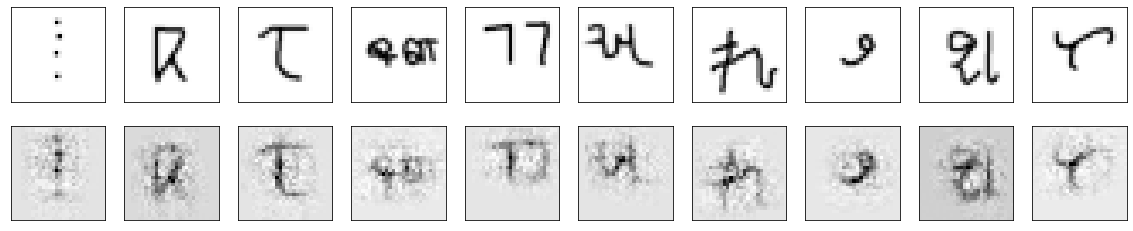

Epoch [1/1], Step[50/121], total_loss 1.0174, rec_loss: 0.0151, genspars: 0.9871 , encospars: 0.0151, averageActivated 0.015123  
Epoch [1/1], Step[100/121], total_loss 0.9473, rec_loss: 0.0134, genspars: 0.9204 , encospars: 0.0134, averageActivated 0.013449  


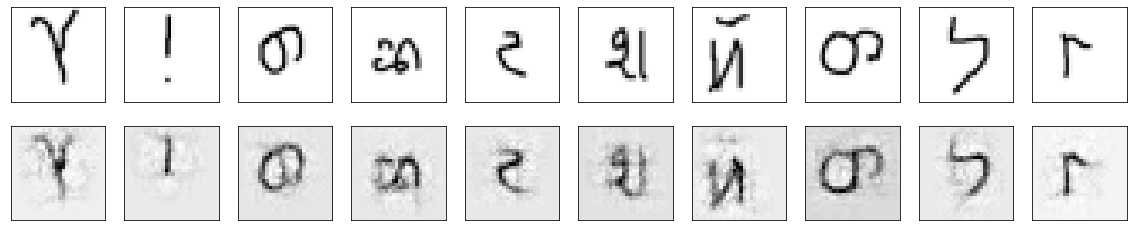

Epoch [1/1], Step[50/121], total_loss 0.8432, rec_loss: 0.0114, genspars: 0.8204 , encospars: 0.0114, averageActivated 0.011398  
Epoch [1/1], Step[100/121], total_loss 0.7768, rec_loss: 0.0108, genspars: 0.7552 , encospars: 0.0108, averageActivated 0.010797  


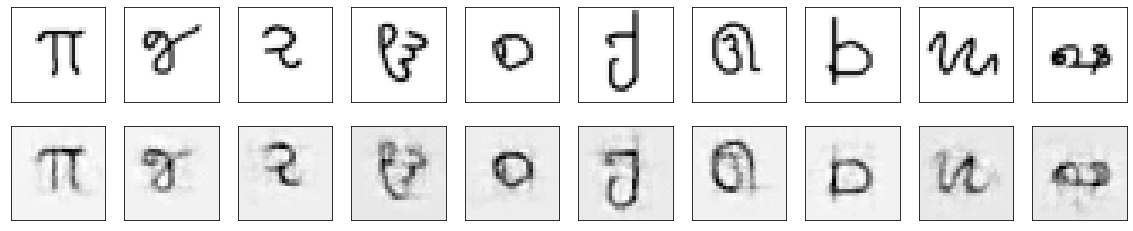

Epoch [1/1], Step[50/121], total_loss 0.6989, rec_loss: 0.0096, genspars: 0.6797 , encospars: 0.0096, averageActivated 0.009617  
Epoch [1/1], Step[100/121], total_loss 0.6601, rec_loss: 0.0096, genspars: 0.6409 , encospars: 0.0096, averageActivated 0.009604  


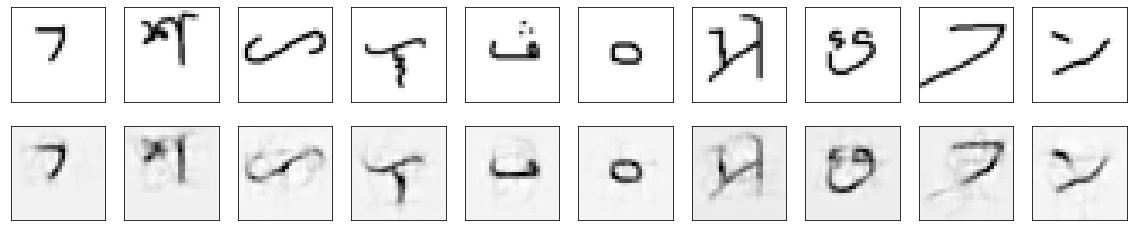

Epoch [1/1], Step[50/121], total_loss 0.6230, rec_loss: 0.0092, genspars: 0.6046 , encospars: 0.0092, averageActivated 0.009205  
Epoch [1/1], Step[100/121], total_loss 0.6020, rec_loss: 0.0083, genspars: 0.5854 , encospars: 0.0083, averageActivated 0.008288  


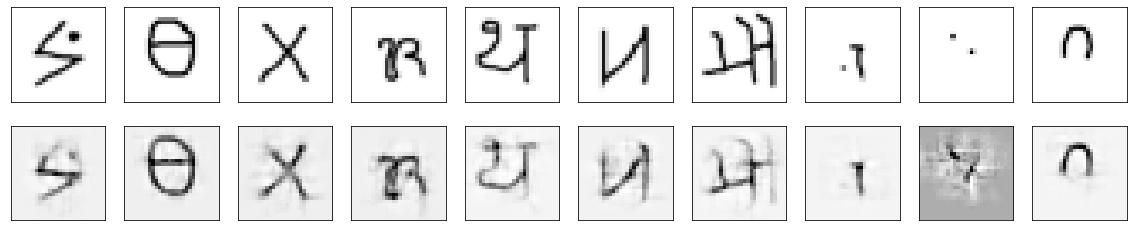

Epoch [1/1], Step[50/121], total_loss 0.5785, rec_loss: 0.0081, genspars: 0.5623 , encospars: 0.0081, averageActivated 0.008073  
Epoch [1/1], Step[100/121], total_loss 0.5655, rec_loss: 0.0084, genspars: 0.5487 , encospars: 0.0084, averageActivated 0.008420  


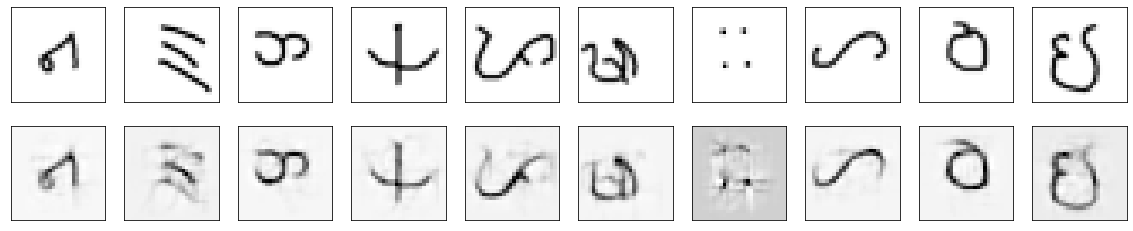

Epoch [1/1], Step[50/121], total_loss 0.5513, rec_loss: 0.0088, genspars: 0.5338 , encospars: 0.0088, averageActivated 0.008762  
Epoch [1/1], Step[100/121], total_loss 0.5401, rec_loss: 0.0081, genspars: 0.5239 , encospars: 0.0081, averageActivated 0.008058  


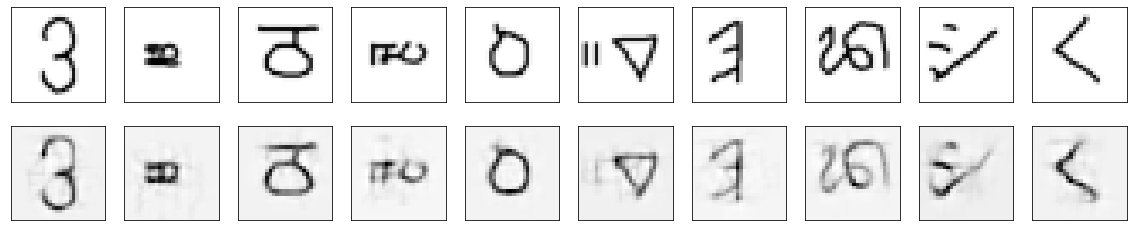

Epoch [1/1], Step[50/121], total_loss 0.5263, rec_loss: 0.0086, genspars: 0.5091 , encospars: 0.0086, averageActivated 0.008630  
Epoch [1/1], Step[100/121], total_loss 0.5158, rec_loss: 0.0079, genspars: 0.5000 , encospars: 0.0079, averageActivated 0.007898  


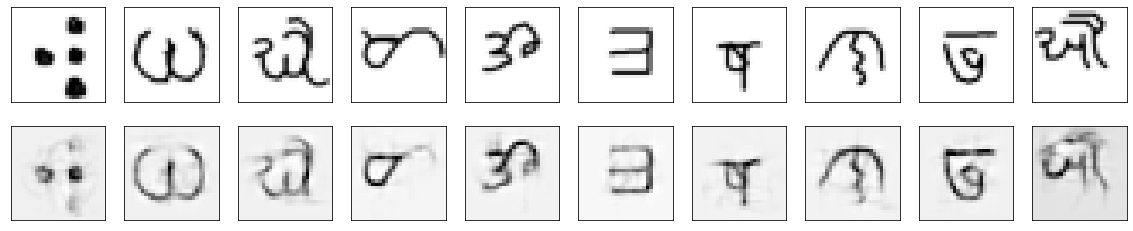

Epoch [1/1], Step[50/121], total_loss 0.5028, rec_loss: 0.0071, genspars: 0.4886 , encospars: 0.0071, averageActivated 0.007112  
Epoch [1/1], Step[100/121], total_loss 0.4956, rec_loss: 0.0079, genspars: 0.4797 , encospars: 0.0079, averageActivated 0.007948  


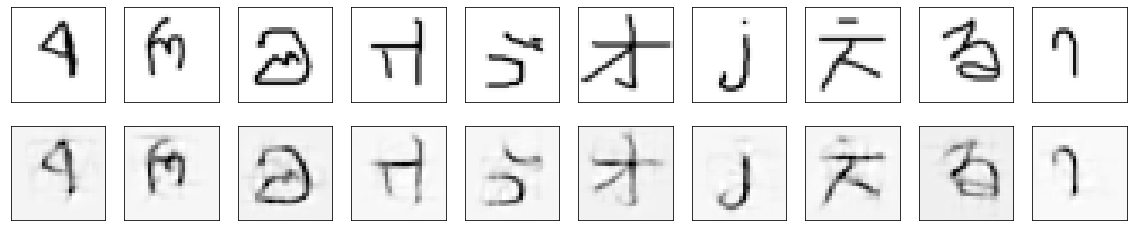

Epoch [1/1], Step[50/121], total_loss 0.4837, rec_loss: 0.0070, genspars: 0.4697 , encospars: 0.0070, averageActivated 0.007033  
Epoch [1/1], Step[100/121], total_loss 0.4796, rec_loss: 0.0077, genspars: 0.4643 , encospars: 0.0077, averageActivated 0.007653  


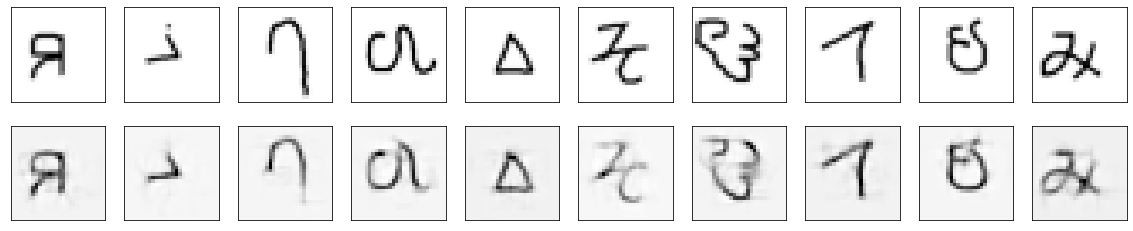

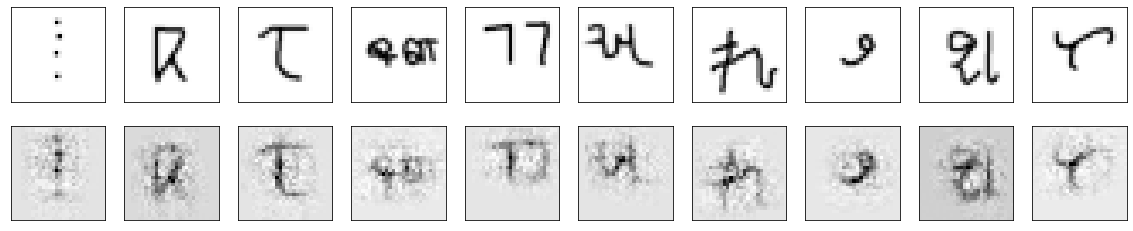

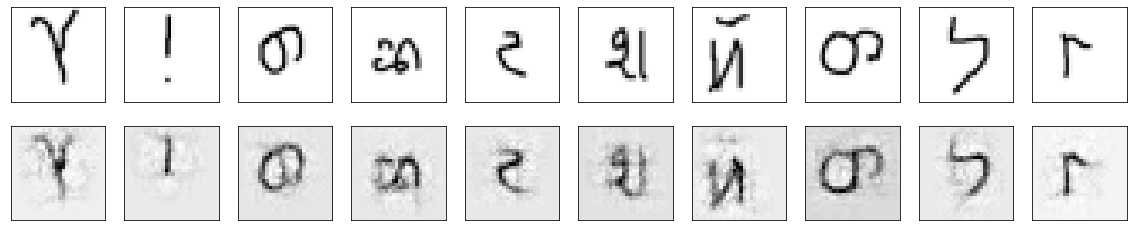

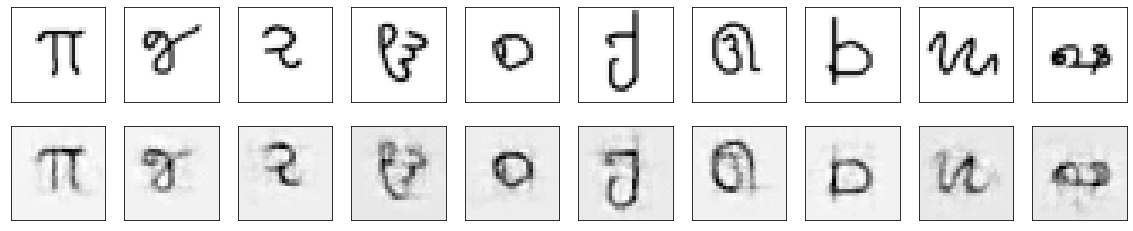

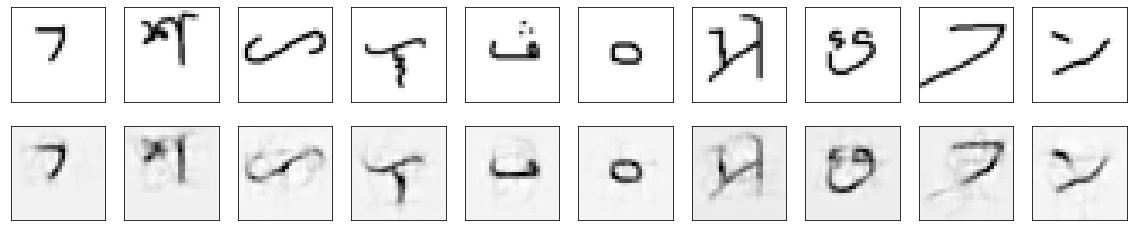

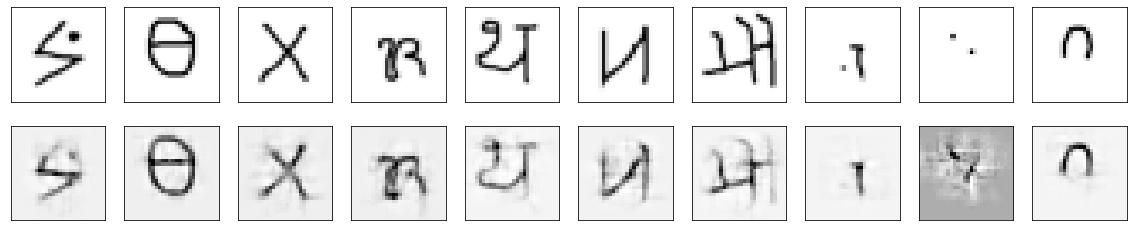

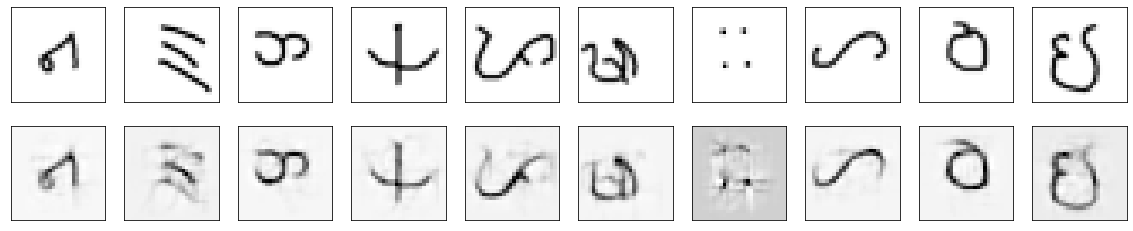

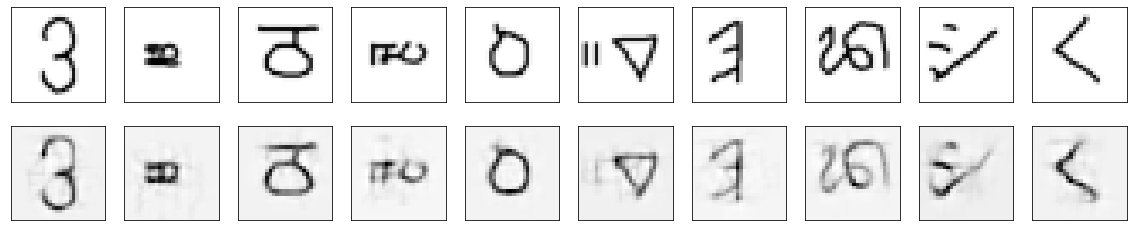

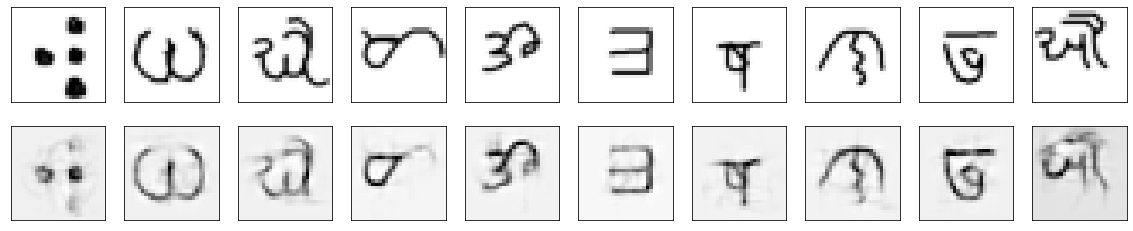

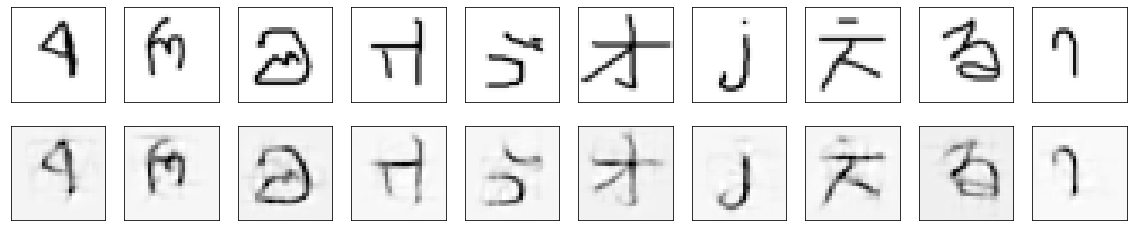

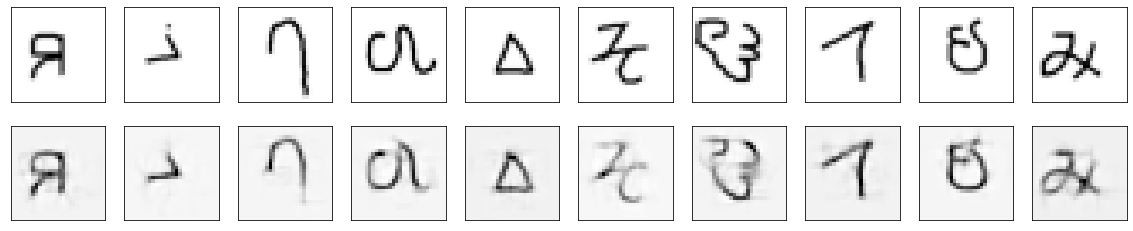

In [ ]:
## Learning

from TrainEncDecMutliLayerWTA import FullLearning_Regular, train_AE, learn_AE

AddLRs = {"genspars": 0.001, "encspars": 0.00, "lpercomp": 0.000,"pairwise": 0.0000}
# le paramètre 'genspars' ajoute une contrainte de sparsité dans le processus de créations des primitives, et 'amène' ainsi le modèle à sortir des primitives distinctes et moins bruitées


LRs = [0.0002]
NbEpochs = 10
print(AddLRs["genspars"])

mode = 'WTA'
FullLearning_Regular(e, device, train_loader, test_loader, NbEpochs, LRs, mode = mode, AddLRs=AddLRs, WithPairwise=False, nbmax=2)

# on choisit un nbmax faible (=2) pour faciliter l'obtention de primitives ayant du sens --> non bruitées, motifs correspondant à des activations ciblées 

# affichage des reconstructions sur les datasets de train puis test

'\na, b, c, d= Stats_AE(e, mode, device, 10, train_loader)\nprint (a[0,:,0])\nprint (a[3,:,0])\nprint (a[4,:,0])\n\nK = np.matmul( a[:,:,0].squeeze(), a[:,:,0].squeeze().transpose())\nprint (K)\n'

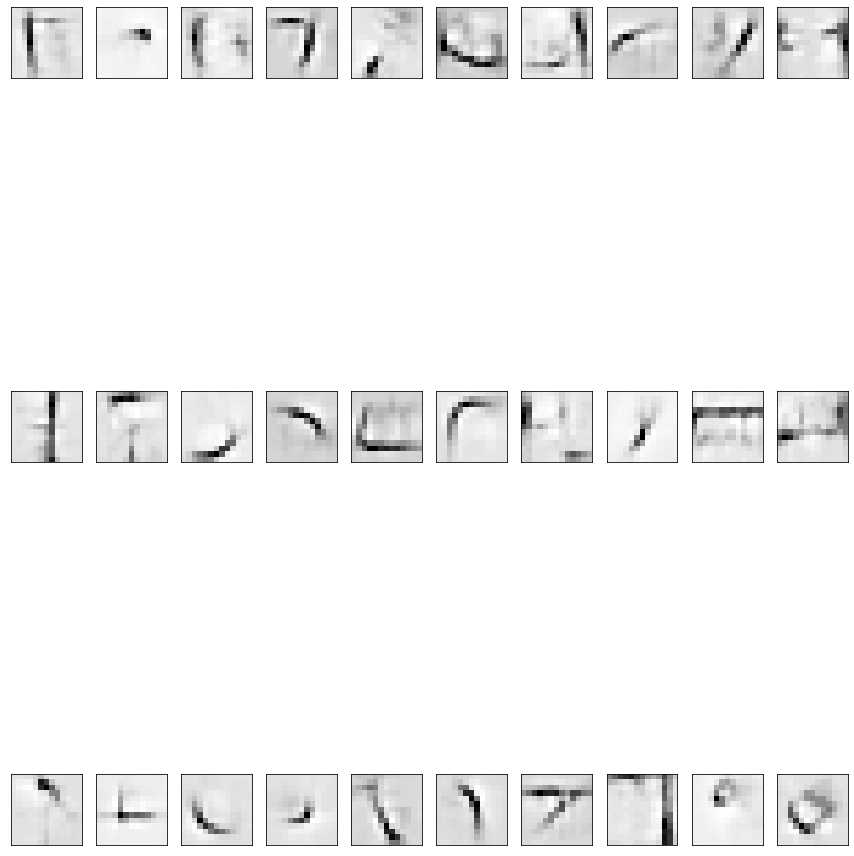

In [ ]:
from EncoderDecoderMultiLayerWTA import visualiseFiltres 
from Stats import Stats_AE

visualiseFiltres(e)

# visualisation des primitives